FAKE NEWS DETECTIO CHALLANGE


In [6]:
# 1. SETUP & LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud # Added this import

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# 2. LOAD DATA FROM GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

true_path_1 = '/content/drive/MyDrive/Fake_News_Detection/Data_lables/True.csv'
true_path_2 = '/content/drive/MyDrive/Fake_News_Detection/Data_lables/True_1.csv'
fake_path = '/content/drive/MyDrive/Fake_News_Detection/Data_lables/Fake.csv'

print("⏳ Loading datasets...")
try:
    df_true1 = pd.read_csv(true_path_1)
    df_true2 = pd.read_csv(true_path_2)
    df_fake = pd.read_csv(fake_path)
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: {e}. Please check your Google Drive paths.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Loading datasets...
✅ All datasets loaded successfully.


In [8]:
# 3. DATA MERGING & PREPARATION

# Merging the two 'True' datasets first
df_true = pd.concat([df_true1, df_true2], axis=0).reset_index(drop=True)

# Add labels: 1 for Real/True, 0 for Fake
df_true['label'] = 1
df_fake['label'] = 0

# Combine True and Fake datasets
df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)

# Combine Title and Text (Title often contains emotional triggers useful for detection)
df['content'] = df['title'] + " " + df['text']

# Drop columns we don't need for training
df = df.drop(columns=['title', 'text', 'subject', 'date'])

# Shuffle the dataset to prevent the model from learning order-based patterns
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total Combined Records: {df.shape[0]}")

Total Combined Records: 66315



--- 📊 EDA: Exploratory Data Analysis ---


/tmp/ipython-input-529701101.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


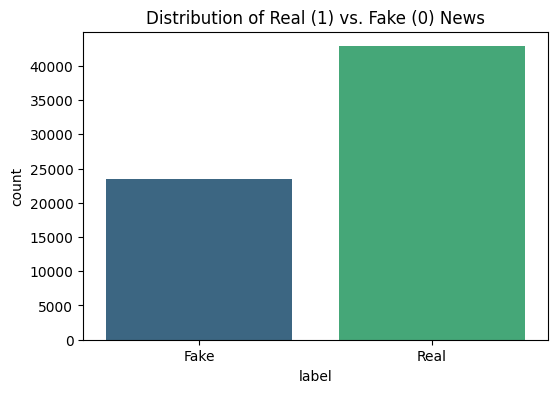


Missing Values:
label      0
content    0
dtype: int64


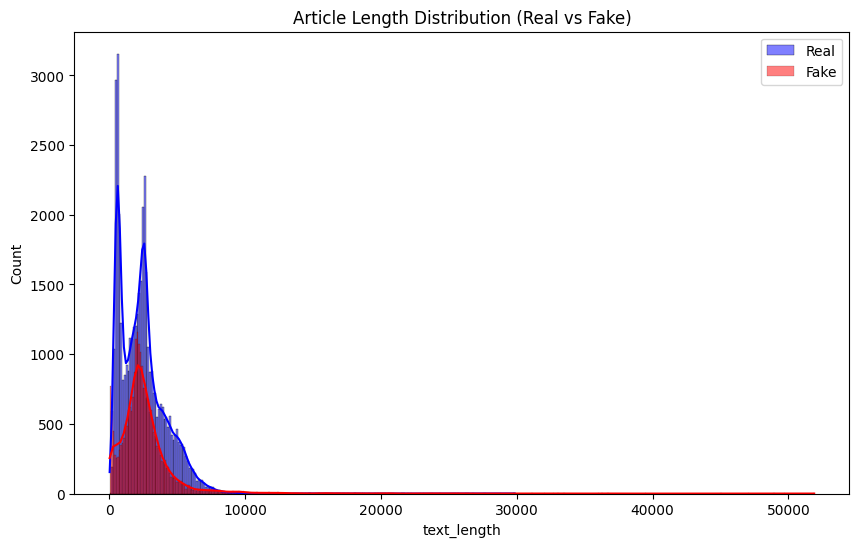


Generating Word Clouds (this takes a moment)...


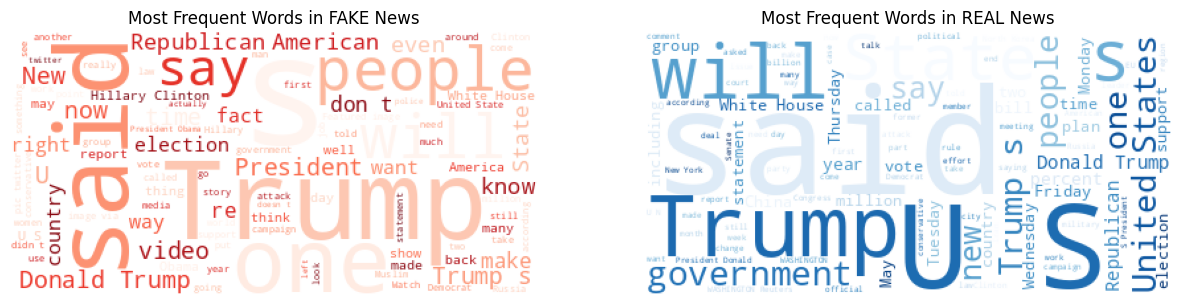

In [10]:
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# "Data Exploration" & "Visualization"

print("\n--- 📊 EDA: Exploratory Data Analysis ---")

# 4.1 Check for Class Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real (1) vs. Fake (0) News')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# 4.2 Check for Nulls
print(f"\nMissing Values:\n{df.isnull().sum()}")
df.dropna(inplace=True) # Simple handling if any exist

# 4.3 Feature Engineering: Text Length Analysis
# Hypothesis: Fake news might be shorter or have different length distributions
df['text_length'] = df['content'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df[df['label']==1]['text_length'], color='blue', label='Real', kde=True, alpha=0.5)
sns.histplot(df[df['label']==0]['text_length'], color='red', label='Fake', kde=True, alpha=0.5)
plt.title('Article Length Distribution (Real vs Fake)')
plt.legend()
plt.show()

# 4.4 Word Clouds (Visualizing High-Frequency Words)
# This is great for the "Presentation" deliverable
print("\nGenerating Word Clouds (this takes a moment)...")
fake_text = " ".join(df[df['label'] == 0]['content'].head(1000)) # subset for speed
real_text = " ".join(df[df['label'] == 1]['content'].head(1000))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(max_words=100, background_color="white", colormap="Reds").generate(fake_text))
plt.title("Most Frequent Words in FAKE News")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(max_words=100, background_color="white", colormap="Blues").generate(real_text))
plt.title("Most Frequent Words in REAL News")
plt.axis("off")
plt.show()

In [11]:
# 5. PRE-PROCESSING (Stemming & Cleaning)
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_and_stem(text):
    # Remove non-alphabetic chars
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    # Stemming (reducing words to root form)
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

print("\n⏳ Pre-processing text (this may take a few minutes)...")
# Using a subset (first 10,000 rows) to save time during testing.
# REMOVE [.iloc[:10000]] below to run on the full dataset for final results!
df_subset = df.iloc[:10000].copy()
df_subset['clean_content'] = df_subset['content'].apply(clean_and_stem)
print("✅ Text cleaning complete.")


⏳ Pre-processing text (this may take a few minutes)...
✅ Text cleaning complete.


In [12]:
# 6. VECTORIZATION & SPLITTING

X = df_subset['clean_content']
y = df_subset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization (n-grams allow capturing phrases like "white house")
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, ngram_range=(1,2), stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print(f"Feature matrix shape: {tfidf_train.shape}")

Feature matrix shape: (8000, 917580)



🎯 Final Model Accuracy: 98.6%


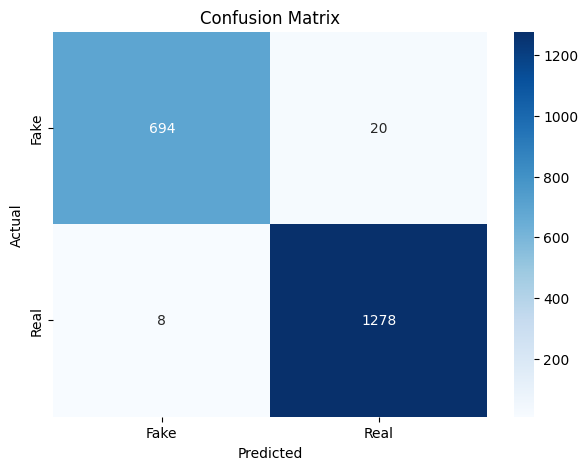


📋 Classification Report:

              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98       714
        Real       0.98      0.99      0.99      1286

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



In [13]:
# 7. MODEL TRAINING & EVALUATION
# Using PassiveAggressiveClassifier as suggested in the doc
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)

print(f'\n🎯 Final Model Accuracy: {round(score*100, 2)}%')

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


In [14]:
# 8. EXPLAINABILITY

# Identifying which words fooled the model or triggered detection
def get_top_features(vectorizer, model, n=15):
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\n🔍 EXPLAINABILITY: Top Keywords Driving Decisions")
    print(f"{'Fake Indicators':<30} | {'Real Indicators':<30}")
    print("-" * 65)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print(f"{fn_1:<30} | {fn_2:<30}")

get_top_features(tfidf_vectorizer, pac)


🔍 EXPLAINABILITY: Top Keywords Driving Decisions
Fake Indicators                | Real Indicators               
-----------------------------------------------------------------
video                          | reuter                        
imag                           | washington reuter             
hillari                        | wednesday                     
gop                            | washington                    
featur imag                    | thursday                      
featur                         | tuesday                       
watch                          | reuter presid                 
presid obama                   | presid donald                 
obama                          | friday                        
wire                           | trump said                    
mr                             | presidenti                    
read                           | monday                        
getti                          | said statement     

In [15]:
# ==========================================
# 9. EXPORT MODEL TO GOOGLE DRIVE
# ==========================================
import pickle
import os

model_filename = '/content/drive/MyDrive/Fake_News_Detection/fake_news_classifier.pkl'
vectorizer_filename = '/content/drive/MyDrive/Fake_News_Detection/tfidf_vectorizer.pkl'

print("⏳ Saving model and vectorizer to Google Drive...")

# Save the trained model
with open(model_filename, 'wb') as model_file:
    pickle.dump(pac, model_file)

# Save the vectorizer which is needed to transform new text later)
with open(vectorizer_filename, 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

# Verify the files were created
if os.path.exists(model_filename) and os.path.exists(vectorizer_filename):
    print(f"✅ Success! Files saved to your Drive:\n 1. {model_filename}\n 2. {vectorizer_filename}")
    print("Files are now saved and can be downloaded or loaded in a separate script for your dashboard.")
else:
    print("❌ Error: Files were not saved. Check your Drive permissions.")

⏳ Saving model and vectorizer to Google Drive...
✅ Success! Files saved to your Drive:
 1. /content/drive/MyDrive/Fake_News_Detection/fake_news_classifier.pkl
 2. /content/drive/MyDrive/Fake_News_Detection/tfidf_vectorizer.pkl
Files are now saved and can be downloaded or loaded in a separate script for your dashboard.
